In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [191]:
#import the dataset
japan = pd.read_csv('japanese_census.csv')
japan.head()

,Unnamed: 0,Year,Prefecture,Age Lower Bound,Age Upper Bound,Gender,Population
0,0,1920,Hokkaido,0,4.0,Male,190044
1,1,1920,Hokkaido,0,4.0,Female,186632
2,2,1920,Hokkaido,5,9.0,Male,161814
3,3,1920,Hokkaido,5,9.0,Female,157556
4,4,1920,Hokkaido,10,14.0,Male,138018


In [192]:
#to find the datatype of each feature of the dataset
japan.dtypes

Unnamed: 0           int64
Year                 int64
Prefecture          object
Age Lower Bound      int64
Age Upper Bound    float64
Gender              object
Population           int64
dtype: object

In [193]:
#to check if there are any null values in the dataset
japan.isnull().sum()

Unnamed: 0            0
Year                  0
Prefecture            0
Age Lower Bound       0
Age Upper Bound    1880
Gender                0
Population            0
dtype: int64

In [194]:
#to replace the missing values in 'Age Upper Bound' with the mean of the values
japan_mean = japan['Age Upper Bound'].mean()
japan['Age Upper Bound'].fillna(japan_mean, inplace=True)

In [195]:
#Recheck the null values after replacement of missing values
japan.isnull().sum()

Unnamed: 0         0
Year               0
Prefecture         0
Age Lower Bound    0
Age Upper Bound    0
Gender             0
Population         0
dtype: int64

In [196]:
#to eliminate any unwanted characters that are not recognized, from values in categorical variables
japan['Prefecture'] = japan['Prefecture'].str.replace(',', '')
japan['Gender'] = japan['Gender'].str.replace(',', '')

In [197]:
#label encoding for categorical variables
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

japan['Prefecture'] = label_encoder.fit_transform(japan['Prefecture'])
japan['Gender'] = label_encoder.fit_transform(japan['Gender'])

In [198]:
japan.head()

,Unnamed: 0,Year,Prefecture,Age Lower Bound,Age Upper Bound,Gender,Population
0,0,1920,10,0,4.0,1,190044
1,1,1920,10,0,4.0,0,186632
2,2,1920,10,5,9.0,1,161814
3,3,1920,10,5,9.0,0,157556
4,4,1920,10,10,14.0,1,138018


In [199]:
#split the dataset into independent features and dependent feature
X = japan[['Year', 'Prefecture', 'Age Lower Bound', 'Age Upper Bound', 'Population']]
y = japan[['Gender']]

In [200]:
#Get the male and female classes count in the dataset, since this is a dataset of binary classification
Female = japan[japan['Gender']==1]
Male = japan[japan['Gender']==0]

print(Female.shape, Male.shape)

(16727, 7) (16727, 7)


Since the number of males and females are equal, the dataset is balanced

<AxesSubplot:>

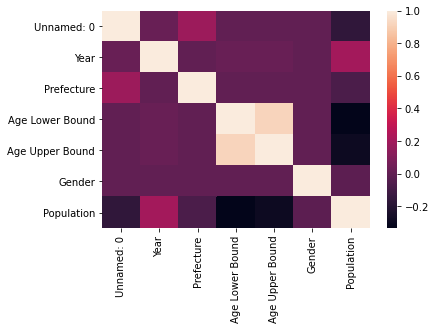

In [201]:
sns.heatmap(japan.corr())

In [209]:
#Split the dataset into training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=1)

In [210]:
#import the modules for the models to be evaluated, both individually as well as stacked
from numpy import mean, std
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [211]:
#Perform Standard Normalization on the dataset
model = StandardScaler().fit(X, y)

In [212]:
#stacking ensemble of models
def get_stacking():
    #define the base models
    level0 = list()
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('dt', DecisionTreeClassifier()))
    level0.append(('bayes', GaussianNB()))
    #define meta learner model
    level1 = LogisticRegression()
    
    #define Stacking Ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    
    return model

In [213]:
#define a function that initializes the objects of the list of models to evaluate. 
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['rc'] = DecisionTreeClassifier()
    models['bayes'] = GaussianNB()
    models['svm'] = SVC()
    models['stacking'] = get_stacking()
    
    return models

In [214]:
#Evaluate a model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [215]:
models = get_models()

In [216]:
#to find the mean and standard deviation of individual models to find the models that are least correlated with each other
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f(%.3f)' %(name, mean(scores), std(scores)))

>lr 0.514(0.013)
>knn 0.504(0.011)
>rc 0.508(0.015)
>bayes 0.505(0.011)
>svm 0.526(0.010)
>stacking 0.518(0.012)


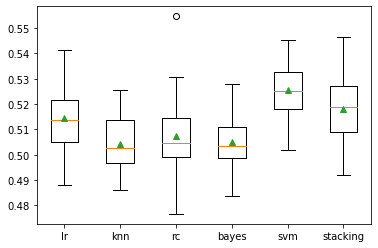

In [217]:
#plotting model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Model Evaluation

to find the roc-auc score of each individual model, as well as the stacked model

In [218]:
from sklearn.metrics import roc_curve, roc_auc_score

In [219]:
models['lr'] = LogisticRegression().fit(X_train, y_train)
models['knn'] = KNeighborsClassifier().fit(X_train, y_train)
models['rc'] = DecisionTreeClassifier().fit(X_train, y_train)
models['bayes'] = GaussianNB().fit(X_train, y_train)
models['svm'] = SVC().fit(X_train, y_train)
models['stacking'] = get_stacking().fit(X_train, y_train)

#logistic regression
ytrain_pred_lr = models['lr'].predict_proba(X_train)
ytest_pred_lr = models['lr'].predict_proba(X_test)

#knn classifier
ytrain_pred_knn = models['knn'].predict_proba(X_train)
ytest_pred_knn = models['knn'].predict_proba(X_test)

#decision tree classifier
ytrain_pred_dt = models['rc'].predict_proba(X_train)
ytest_pred_dt = models['rc'].predict_proba(X_test)

#Naive Bayes CLassifier
ytrain_pred_bayes = models['bayes'].predict_proba(X_train)
ytest_pred_bayes = models['bayes'].predict_proba(X_test)

#stacked models
ytrain_pred_stacking= models['stacking'].predict_proba(X_train)
ytest_pred_stacking = models['stacking'].predict_proba(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

In [220]:
#Logistic Regression
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred_lr[:, 1])))
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred_lr[:, 1])))

RF train roc-auc: 0.5291505444695863
RF test roc-auc: 0.5269242287664925


In [221]:
#K-Nearest Neighbors Classifier
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred_knn[:, 1])))
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred_knn[:, 1])))

RF train roc-auc: 0.75173009047454
RF test roc-auc: 0.5109790439411085


In [222]:
#Decision Trees Classifier
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred_dt[:, 1])))
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred_dt[:, 1])))

RF train roc-auc: 0.9999999928518406
RF test roc-auc: 0.5084676667875754


In [223]:
#Naive-Bayes Classification
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred_bayes[:, 1])))
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred_bayes[:, 1])))

RF train roc-auc: 0.5232976458137318
RF test roc-auc: 0.5101718022951768


In [224]:
#Stacked Model
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred_stacking[:, 1])))
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred_stacking[:, 1])))

RF train roc-auc: 0.6800609140414384
RF test roc-auc: 0.5256542295745203
